In [3]:
%load_ext autoreload
%autoreload 2

# Imports

In [4]:
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from typing import List, get_type_hints, Union, Dict, Any, Callable
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

from encoding_objects.cart_2d_enc_obj import Cart2DEncObj
from utils.noise_functions import add_gaussian_noise
from utils.mask_funcs import cartesian_mask

import os

from utils.makepath import makepath as mkp

In [5]:
root_dir = mkp("..")
print(os.listdir(root_dir))

['scripts', 'requirements.txt', 'mri.egg-info', 'venv', 'README.md', 'figures', 'config', 'LICENSE', 'utils', 'networks', 'tmp', 'dyn_mri_test.py', '.gitignore', 'gradops', 'pyproject.toml', 'gifs', 'data', 'pdhg', 'data_lib', 'wandb', 'encoding_objects', '.git']


In [6]:
TensorType = get_type_hints(torch.Tensor)

In [7]:
print(f"type(TensorType) = {type(TensorType)}")

type(TensorType) = <class 'dict'>


In [8]:
print(f"type(List) = {type(List)}")

type(List) = <class 'typing._SpecialGenericAlias'>


In [9]:
def complex_number_x_true_to_kdata(
        complex_x_true: torch.Tensor, R: int, noise_var: float
) -> torch.Tensor:
    assert complex_x_true.dim() == 3, "must have 3 dimensions"
    assert complex_x_true.shape[0] == 1, "must have 1 channel"
    assert complex_x_true.dtype == torch.complex64, "must have complex64 data type"

    # define the "encoding object" that contains the forward and the adjoint
    # of the MRI acquisition operator
    EncObj = Cart2DEncObj()

    # define some acceleration factor R and some noise variance
    # R = 6
    # noise_var = 0.025
    # noise_var = 0
    undersampling_k_mask = cartesian_mask(complex_x_true.shape, acc=R)
    print(f"undersampling_k_mask.shape = {undersampling_k_mask.shape}")
    print(f"undersampling_k_mask.dtype = {undersampling_k_mask.dtype}")
    assert undersampling_k_mask.dim() == 3, "must have 3 dimensions"
    assert undersampling_k_mask.shape[0] == 1, "must have 1 channel"
    assert undersampling_k_mask.dtype == torch.complex64, "must have complex64 data type"

    # retrospectively generate k-space data from the ground-truth image
    csm = None  # no coil sensitity maps used here --> single coil
    fully_sampled_kdata = EncObj.apply_A(complex_x_true, csm, None)
    undersampled_kdata = EncObj.apply_A(complex_x_true, csm, undersampling_k_mask)

    assert fully_sampled_kdata.dim() == 4, "must have 4 dimensions"
    assert fully_sampled_kdata.shape[0] == 1, "must have 1 channel"
    assert fully_sampled_kdata.dtype == torch.complex64, "must have complex64 data type"

    assert undersampled_kdata.dim() == 4, "must have 4 dimensions"
    assert undersampled_kdata.shape[0] == 1, "must have 1 channel"
    assert undersampled_kdata.dtype == torch.complex64, "must have complex64 data type"

    # add noise to it
    undersampled_kdata_noisy, noise_for_undersampled_kdata = add_gaussian_noise(
        undersampled_kdata, undersampling_k_mask, noise_var=noise_var)
    fully_sampled_kdata_noisy, noise_for_fully_sampled_kdata = add_gaussian_noise(
        fully_sampled_kdata, None, noise_var=noise_var)

    assert undersampled_kdata_noisy.dim() == 4, "must have 4 dimensions"
    assert undersampled_kdata_noisy.shape[0] == 1, "must have 1 channel"
    assert undersampled_kdata_noisy.dtype == torch.complex64, "must have complex64 data type"

    assert fully_sampled_kdata_noisy.dim() == 4, "must have 4 dimensions"
    assert fully_sampled_kdata_noisy.shape[0] == 1, "must have 1 channel"
    assert fully_sampled_kdata_noisy.dtype == torch.complex64, "must have complex64 data type"

    print(f"Shape of noise_for_undersampled_kdata: {noise_for_undersampled_kdata.shape}")
    print(f"Data type of noise_for_undersampled_kdata: {noise_for_undersampled_kdata.dtype}")
    assert noise_for_undersampled_kdata.dim() == 4, "must have 4 dimensions"
    assert noise_for_undersampled_kdata.shape[0] == 1, "must have 1 channel"
    assert noise_for_undersampled_kdata.dtype == torch.complex64, "must have complex64 data type"

    print(f"Shape of noise_for_fully_sampled_kdata: {noise_for_fully_sampled_kdata.shape}")
    print(f"Data type of noise_for_fully_sampled_kdata: {noise_for_fully_sampled_kdata.dtype}")
    assert noise_for_fully_sampled_kdata.dim() == 4, "must have 4 dimensions"
    assert noise_for_fully_sampled_kdata.shape[0] == 1, "must have 1 channel"
    assert noise_for_fully_sampled_kdata.dtype == torch.complex64, "must have complex64 data type"

    return fully_sampled_kdata, fully_sampled_kdata_noisy, \
        undersampled_kdata, undersampled_kdata_noisy, \
            csm, undersampling_k_mask, EncObj


def complex_number_x_true_to_complex_number_3d_results(
        complex_x_true: torch.Tensor, R: int, noise_var: float
) -> torch.Tensor:
    assert complex_x_true.dim() == 3, "must have 3 dimensions"
    assert complex_x_true.shape[0] == 1, "must have 1 channel"
    assert complex_x_true.dtype == torch.complex64, "must have complex64 data type"

    fully_sampled_kdata, fully_sampled_kdata_noisy, \
        undersampled_kdata, undersampled_kdata_noisy, \
            csm, undersampling_mask, EncObj = complex_number_x_true_to_kdata(complex_x_true, R, noise_var)
    print(f"shape of fully_sampled_kdata: {fully_sampled_kdata.shape}")
    print(f"shape of fully_sampled_kdata_corrupted: {fully_sampled_kdata_noisy.shape}")
    print(f"shape of undersampled_kdata: {undersampled_kdata.shape}")
    print(f"shape of undersampled_kdata_corrupted: {undersampled_kdata_noisy.shape}")

    assert fully_sampled_kdata.dim() == 4, "fully_sampled_kdata must have 4 dimensions"
    assert fully_sampled_kdata.shape[0] == 1, "fully_sampled_kdata must have 1 channel"

    assert fully_sampled_kdata_noisy.dim() == 4, "fully_sampled_kdata_corrupted must have 4 dimensions"
    assert fully_sampled_kdata_noisy.shape[0] == 1, "fully_sampled_kdata_corrupted must have 1 channel"

    assert undersampled_kdata.dim() == 4, "undersampled_kdata must have 4 dimensions"
    assert undersampled_kdata.shape[0] == 1, "undersampled_kdata must have 1 channel"

    assert undersampled_kdata_noisy.dim() == 4, "undersampled_kdata_corrupted must have 4 dimensions"
    assert undersampled_kdata_noisy.shape[0] == 1, "undersampled_kdata_corrupted must have 1 channel"

    # generate initial reconstruction
    complex_x0 = EncObj.apply_AH(undersampled_kdata_noisy, csm, undersampling_mask)
    print(f"undersampled_kdata_noisy.shape = {undersampled_kdata_noisy.shape}")
    print(f"undersampling_mask.shape = {undersampling_mask.shape}")
    print(f"complex_x0.shape = {complex_x0.shape}")
    assert complex_x0.dim() == 3, "x0 must have 3 dimensions"
    assert complex_x0.shape[0] == 1, "x0 must have 1 channel"
    assert complex_x0.dtype == torch.complex64, "x0 must have complex64 data type"

    complex_number_3d_results = [
        fully_sampled_kdata.squeeze(0),
        undersampling_mask,
        undersampled_kdata_noisy.squeeze(0),
        complex_x0,
        complex_x_true]
    return complex_number_3d_results


def complex_number_x_true_to_real_number_x_corrupted(
        complex_x_true: torch.Tensor, R: int, noise_var: float
) -> torch.Tensor:
    assert complex_x_true.dim() == 3, "must have 3 dimensions"
    assert complex_x_true.shape[0] == 1, "must have 1 channel"
    assert complex_x_true.dtype == torch.complex64, "must have complex64 data type"

    real_number_results = complex_number_x_true_to_real_number_results(complex_x_true, R, noise_var)

    real_x_corrupted = real_number_results[-2]
    assert real_x_corrupted.dim() == 2, "real_x_corrupted must have 2 dimensions"
    assert real_x_corrupted.dtype == torch.float32, "real_x_corrupted must have float32 data type"

    return real_x_corrupted


def complex_number_x_true_to_real_number_results(
        complex_x_true: torch.Tensor, R: int, noise_var: float
# ) -> torch.Tensor:
) -> List[torch.Tensor]:
    assert complex_x_true.dim() == 3, "must have 3 dimensions"
    assert complex_x_true.shape[0] == 1, "must have 1 channel"
    assert complex_x_true.dtype == torch.complex64, "must have complex64 data type"

    # generate initial reconstruction
    complex_number_results = complex_number_x_true_to_complex_number_3d_results(complex_x_true, R, noise_var)
    assert len(complex_number_results) == 5, "results must have 5 elements"

    real_number_results = []
    for i in range(len(complex_number_results)):
        complex_number_result = complex_number_results[i]
        assert complex_number_result.dim() == 3, "must have 3 dimensions"
        assert complex_number_result.shape[0] == 1, "must have 1 channel"
        assert complex_number_result.dtype == torch.complex64, "must have complex64 data type"

        # real_number_result = complex_number_result[0, ...].abs()
        real_number_result = complex_number_result.squeeze(0).abs()
        assert real_number_result.dim() == 2, "must have 2 dimensions"
        assert real_number_result.dtype == torch.float32, "must have float32 data type"

        real_number_results.append(real_number_result)
    # real_number_results = torch.stack(real_number_results)
    return real_number_results


def plot_example(complex_x_true: torch.Tensor) -> None:
    assert complex_x_true.dim() == 3, "must have 3 dimensions"
    assert complex_x_true.shape[0] == 1, "must have 1 channel"
    assert complex_x_true.dtype == torch.complex64, "must have complex64 data type"

    # plot the results
    fig, ax = plt.subplots(1, 5)

    fig.set_size_inches(20, 5)

    cmap = plt.cm.Greys_r
    clim_img = [0, 5e-4]
    titles = ["kdata full", "mask", "undersampled noisy\n kdata", "zero-filled", "target"]
    real_number_results = complex_number_x_true_to_real_number_results(complex_x_true, R=6, noise_var=0)
    assert len(real_number_results) == 5, "results must have 5 elements"


    for i in range(len(titles)):
    # for i in range(1):
        # TODO: Is clim the clipping???
        clim = [0, 1] if i == 1 else clim_img
        real_number_result = real_number_results[i]
        assert real_number_result.dim() == 2, "real_number_result must have 2 dimensions"
        assert real_number_result.dtype == torch.float32, "real_number_result must have float32 data type"
        ax[i].imshow(real_number_result, cmap=cmap, clim=clim)
        ax[i].set_title(titles[i], fontsize=6)
        print(f"{titles[i]}: {real_number_result.min()}, {real_number_result.max()}")
    plt.setp(ax, xticks=[], yticks=[])

x_true_example shape: torch.Size([1, 320, 320])
undersampling_k_mask.shape = torch.Size([1, 320, 320])
undersampling_k_mask.dtype = torch.complex64
Shape of noise_for_undersampled_kdata: torch.Size([1, 1, 320, 53])
Data type of noise_for_undersampled_kdata: torch.complex64
Shape of noise_for_fully_sampled_kdata: torch.Size([1, 1, 320, 320])
Data type of noise_for_fully_sampled_kdata: torch.complex64
shape of fully_sampled_kdata: torch.Size([1, 1, 320, 320])
shape of fully_sampled_kdata_corrupted: torch.Size([1, 1, 320, 320])
shape of undersampled_kdata: torch.Size([1, 1, 320, 320])
shape of undersampled_kdata_corrupted: torch.Size([1, 1, 320, 320])
undersampled_kdata_noisy.shape = torch.Size([1, 1, 320, 320])
undersampling_mask.shape = torch.Size([1, 320, 320])
complex_x0.shape = torch.Size([1, 320, 320])
kdata full: 5.477178177670794e-08, 0.02264457754790783
mask: 0.0, 1.0
undersampled noisy
 kdata: 0.0, 0.02264457754790783
zero-filled: 6.322826351379263e-08, 0.0005961071001365781
tar

/home/GIT/image-denoising-unet-tv-tgv/utils/noise_functions.py:28: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:300.)
  kspace_data = torch.masked_select(kspace_data, mask.to(torch.bool)).view(


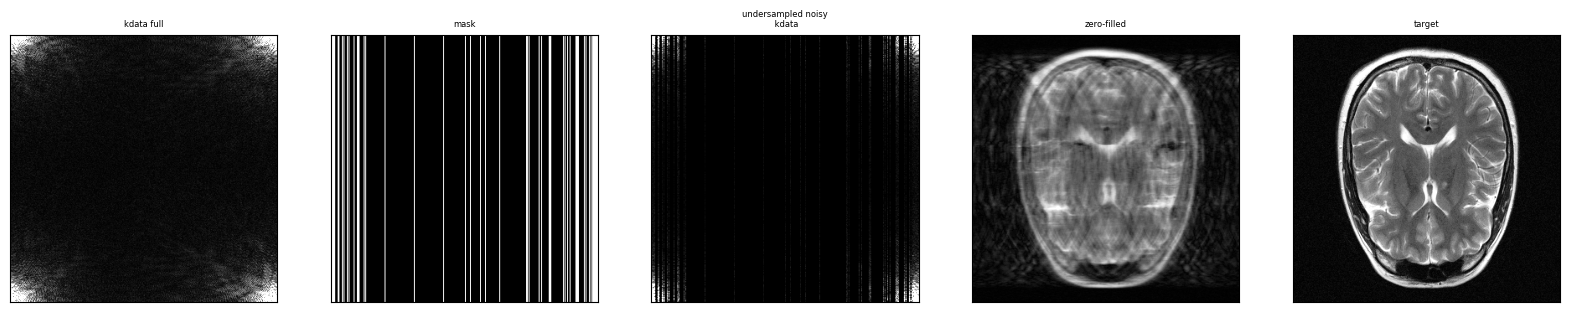

In [10]:
# load some ground-truth data (currently assumed to be in the same folder)
# path = os.getcwd()
slice_id = 0  # only one slice for xtrue_example.pt
mri_data_dir = mkp(root_dir, "tmp", "mri_data")
xtrue_example_path = mkp(mri_data_dir, "x_true_example.pt")
x_true_example = torch.load(xtrue_example_path)[[slice_id], ...]
print(f"x_true_example shape: {x_true_example.shape}")
plot_example(x_true_example)

undersampling_k_mask.shape = torch.Size([1, 320, 320])
undersampling_k_mask.dtype = torch.complex64


Shape of noise_for_undersampled_kdata: torch.Size([1, 1, 320, 80])
Data type of noise_for_undersampled_kdata: torch.complex64
Shape of noise_for_fully_sampled_kdata: torch.Size([1, 1, 320, 320])
Data type of noise_for_fully_sampled_kdata: torch.complex64
shape of fully_sampled_kdata: torch.Size([1, 1, 320, 320])
shape of fully_sampled_kdata_corrupted: torch.Size([1, 1, 320, 320])
shape of undersampled_kdata: torch.Size([1, 1, 320, 320])
shape of undersampled_kdata_corrupted: torch.Size([1, 1, 320, 320])
undersampled_kdata_noisy.shape = torch.Size([1, 1, 320, 320])
undersampling_mask.shape = torch.Size([1, 320, 320])
complex_x0.shape = torch.Size([1, 320, 320])
Min: 4.697721678326161e-08, Max: 0.0005775191821157932
Min: 0.0, Max: 0.022641092538833618


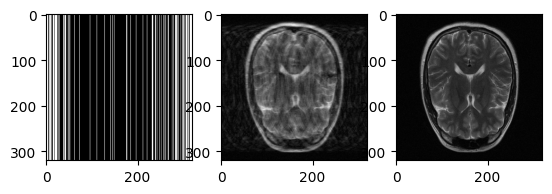

In [11]:
rescaled_x_true_example = x_true_example / x_true_example.abs().max()
complex_results = complex_number_x_true_to_complex_number_3d_results(
    x_true_example,
    # R=6,
    R=4,
    # R=2,
    # noise_var=0
    noise_var=0.01
)
kdata_original = complex_results[0]
x_zero_filled = complex_results[3]
kdata_noisy = complex_results[2]
mask = complex_results[1]
print(f"Min: {x_zero_filled.abs().min()}, Max: {x_zero_filled.abs().max()}")
print(f"Min: {kdata_noisy.abs().min()}, Max: {kdata_noisy.abs().max()}")

plt.subplot(1, 3, 1)
plt.imshow(mask.squeeze(0).abs(), cmap="gray")

plt.subplot(1, 3, 2)
plt.imshow(x_zero_filled.squeeze(0).abs(), cmap="gray")

plt.subplot(1, 3, 3)
plt.imshow(x_true_example.squeeze(0).abs(), cmap="gray")

In [12]:
print(f"type of mask: {type(mask)}")

type of mask: <class 'torch.Tensor'>


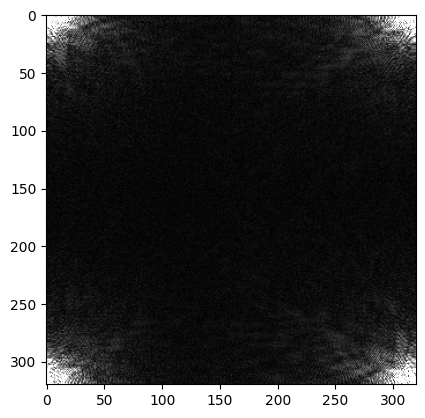

In [13]:
plt.imshow(kdata_original.squeeze(0).abs(), cmap="gray", clim = [0, 5e-4])

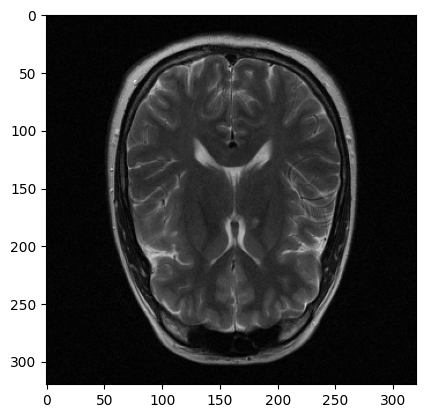

In [14]:
plt.imshow(rescaled_x_true_example.squeeze(0).abs(), cmap="gray")

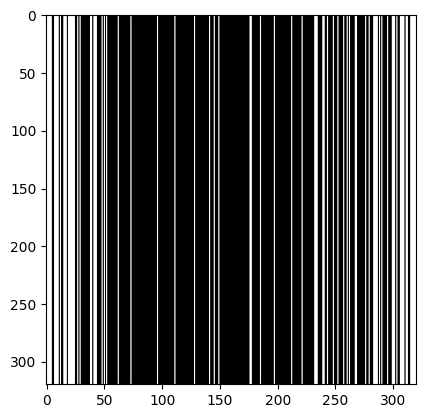

In [15]:
plt.imshow(mask.squeeze(0).abs(), cmap="gray")

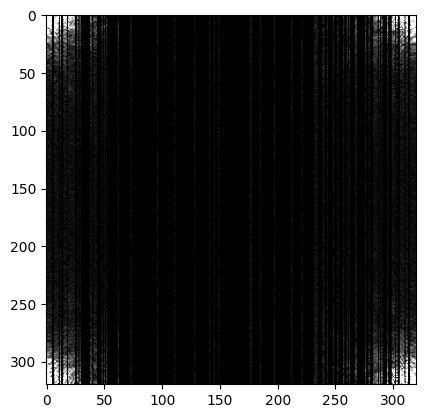

In [16]:
plt.imshow(kdata_noisy.squeeze(0).abs(), cmap="gray", clim = [0, 5e-4])

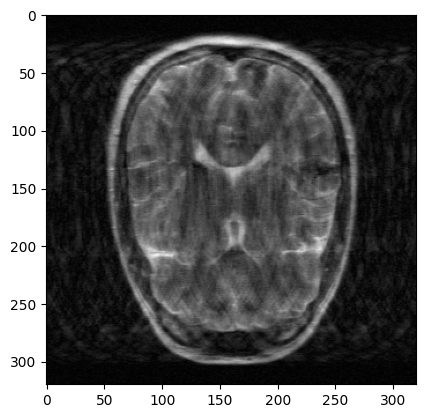

In [17]:
plt.imshow(x_zero_filled.squeeze(0).abs(), cmap="gray")

In [18]:
# xTV = tv_pdhg_solver(
#     device="cpu",
#     num_iters=256,
#     lambda_reg=0.01,
#     kdata=rescaled_kdata_noisy,
#     kmask=mask,
#     state=rescaled_x_zero_filled
# )
# plt.imshow(xTV.squeeze(0).abs(), cmap="gray")

In [19]:
# xTGV = tgv_pdhg_solver(
#     device="cpu",
#     num_iters=256,
#     lambda_reg={
#         "lambda0_w": 0.01,
#         "lambda1_v": 0.01,
#     },
#     kdata=rescaled_kdata_noisy,
#     kmask=mask,
#     state=rescaled_x_zero_filled
# )
# plt.imshow(xTGV.squeeze(0).abs(), cmap="gray")

In [20]:
L = torch.sqrt(torch.tensor([9]))
# L = torch.sqrt(torch.tensor([13]))
# L = torch.tensor([1e3])
sigma = 1 / L
tau = 1 / L

rescale_factor = 1000

rescaled_x_zero_filled = x_zero_filled * rescale_factor
rescaled_kdata_noisy = kdata_noisy * rescale_factor
print(f"Min: {rescaled_x_zero_filled.abs().min()}, Max: {rescaled_x_zero_filled.abs().max()}")
print(f"Min: {rescaled_kdata_noisy.abs().min()}, Max: {rescaled_kdata_noisy.abs().max()}")

Min: 4.697721669799648e-05, Max: 0.5775191783905029
Min: 0.0, Max: 22.64109230041504


In [21]:
EncObj = Cart2DEncObj()
from networks.prox_ops import clipact

In [22]:
def custom_psnr(a, b):
    max_I = max(a.abs().max(), b.abs().max())
    mse = torch.mean((a.abs() - b.abs()) ** 2)
    psnr = 20 * torch.log10(max_I) - 10 * torch.log10(mse)
    return psnr

# TV

In [23]:
from networks.grad_ops import GradOperators
GradOps = GradOperators(
    dim=2, mode="forward",
    padmode="reflect"
)

In [24]:
def tv_pdhg(
        nu, x0, y, sigma, tau, theta, lambda_reg, A, AH, G, GH,
        return_state=False):

    """
        implemented according to
        https://iopscience.iop.org/article/10.1088/0031-9155/57/10/3065/pdf, algorithm 4
        """
    # workaround for mixed complex/real addcmul
    # for pytorch <= 1.13 compatibility
    if y.is_complex():
        addcmul = lambda x1, x2, x3: torch.view_as_complex(torch.addcmul(
            torch.view_as_real(x1), torch.view_as_real(x2), x3))
    else:
        addcmul = torch.addcmul

    if isinstance(x0, dict):
        p, q, xbar, x1 = x0["p"], x0["q"], x0["xbar"], x0["x1"]
    else:
        p = torch.zeros(y.shape, dtype=y.dtype, device=x0.device)
        q = torch.zeros(
            x0.shape[0], 2, *x0.shape[1:], dtype=x0.dtype,
            device=x0.device)
        xbar = x0
        x1 = x0

    for ku in range(nu):
        p = addcmul(p, A(xbar) - y, sigma)
        p = p * (1 / (1 + sigma))
        q = addcmul(q, G(xbar), sigma)
        q = clipact(q, lambda_reg)
        step = AH(p) + GH(q)
        x1 = addcmul(x1, step, -tau)
        xbar = addcmul(x1, step, -tau * theta)

    # f = x0
    # iterator = range(nu)
    # for i in iterator:
    #     # update p
    #     # p = (p + tau * (A(u_bar) - f)) / (tau + 1.0)
    #     p = (p + tau * (A(xbar) - f)) / (tau + 1.0)
    #     # update q
    #     # q = self.P_lambda(q + tau * self.nabla_h(u_bar))
    #     q = clipact(q + tau * G(xbar), lambda_reg)

    #     # u_next = u - sigma * AH(p) + sigma * self.div_h_v(q)
    #     x1 = x0 - sigma * AH(p) + sigma * GH(q)

    #     # u_bar = u_next + theta * (u_next - u)
    #     xbar = x1 + theta * (x1 - x0)

    #     # u = u_next
    #     x0 = x1

    #     # with torch.no_grad():
    #     #     torch.cuda.empty_cache()

    if return_state:
        return x1, {"p": p, "q": q, "xbar": xbar, "x1": x1}
    return x1

In [25]:
# xTV, state = tv_pdhg(
#     nu=256, # number of iterations
#     x0=rescaled_x_zero_filled, # initial reconstruction
#     y=rescaled_kdata_noisy, # undersampled noisy k-space data
#     tau=tau,
#     sigma=sigma,
#     theta=torch.ones(1),
#     lambda_reg=torch.Tensor([0.01]),
#         A = lambda x: EncObj.apply_A(x, None, mask),
#         AH = lambda x: EncObj.apply_AH(x, None, mask),
#     G=GradOps.apply_G,
#     GH=GradOps.apply_GH,
#     return_state=True,
# )

In [26]:
# from pdhg.mri_tv_pdhg import MriTvPdhgTorch
# tv_pdhg_solver = MriTvPdhgTorch(
#     device="cpu",
#     lambda_reg=0.01
# )

from pdhg.mri_pdhg import MriPdhgTorch
tv_pdhg_solver = MriPdhgTorch(
    device="cpu",
    # sigma=sigma,
    # tau=tau,
    # theta=1.0,
    pdhg_algorithm="tv", # total variation
    # tqdm=tqdm
    )


xTV = tv_pdhg_solver.forward(
    num_iters=256,
    lambda_reg=0.01,
    kdata=rescaled_kdata_noisy,
    kmask=mask,
    state=rescaled_x_zero_filled,
    tqdm=tqdm
)


TypeError: MriPdhgTorch.forward() got an unexpected keyword argument 'tqdm'

Min: 1.9722806428035256e-06, Max: 0.5741053223609924


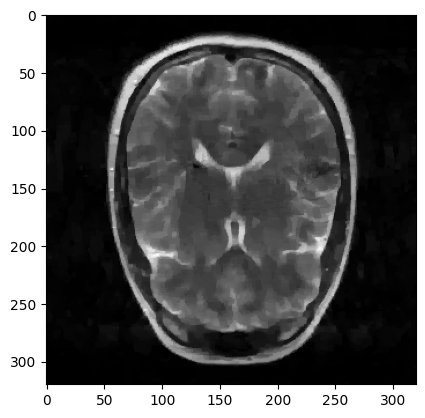

In [25]:
print(f"Min: {xTV.squeeze().abs().min()}, Max: {xTV.squeeze().abs().max()}")
plt.imshow(xTV.squeeze().abs(), cmap="gray")

In [26]:
print(f"TV PSNR custom: {custom_psnr(xTV.squeeze(0), rescaled_x_true_example.squeeze(0))}")

TV PSNR custom: 24.773574829101562


In [27]:
tv_psnr_skimage = peak_signal_noise_ratio(
    rescaled_x_true_example.squeeze(0).abs().numpy(),
    xTV.squeeze(0).abs().numpy()
)
print(f"TV PSNR skimage: {tv_psnr_skimage}")

TV PSNR skimage: 24.773574063047036


In [28]:
tv_psnr_skimage_range = peak_signal_noise_ratio(
    rescaled_x_true_example.squeeze(0).abs().numpy(),
    xTV.squeeze(0).abs().numpy(),
    data_range=max(rescaled_x_true_example.abs().max(), xTV.abs().max())
)
print(f"TV PSNR skimage range: {tv_psnr_skimage_range}")

TV PSNR skimage range: 24.773574063047036


# TGV

In [29]:
# from gradops.gradops_torch import GradOpsTorch

# grad_ops = GradOpsTorch()

In [30]:
# def tgv_pdhg(
#         num_iters: int,
#         x0: Union[Dict[str, Any], torch.Tensor],
#         kdata: torch.Tensor,
#         sigma, tau,
#         # theta,
#         lambda0_w: Union[float, torch.Tensor],
#         lambda1_v: Union[float, torch.Tensor],
#         A: Callable, AH: Callable,
#         # G, GH,
#         return_state: bool = False, tqdm: Callable = None,
#         v=None, p=None, q=None, r=None, x_bar=None, v_bar=None,
#         device=None):
#     """
#     Adapted from Algorithm 2 from
#     "Second Order Total Generalized Variation (TGV) for MRI"
#     by Florian Knoll, Kristian Bredies,
#     Thomas Pock, and Rudolf Stollberger.
#     """

#     # workaround for mixed complex/real addcmul
#     # for pytorch <= 1.13 compatibility
#     # def addcmul(x1, x2, x3):
#     #     if x1.is_complex():
#     #         x1 = torch.view_as_real(x1)
#     #     if x2.is_complex():
#     #         x2 = torch.view_as_real(x2)
#     #     return torch.view_as_complex(torch.addcmul(x1, x2, x3))
#     addcmul = torch.addcmul

#     print(f"type(addcmul) = {type(addcmul)}")

#     if isinstance(x0, dict):
#         x = x0["x"]
#         device = x0.get("device", None)
#         v = x0.get("v", None)
#         p = x0.get("p", None)
#         q = x0.get("q", None)
#         r = x0.get("r", None)
#         x_bar = x0.get("x_bar", None)
#         v_bar = x0.get("v_bar", None)
#     elif isinstance(x0, torch.Tensor):
#         x = x0
#     else:
#         raise ValueError(
#             "Unknown type for x0. " +
#             f"Expected dict or torch.Tensor, got {type(x0)}")

#     # for ku in range(nu):
#     #     p = addcmul(p, A(xbar) - y, sigma)
#     #     p = p * (1 / (1 + sigma))
#     #     q = addcmul(q, G(xbar), sigma)
#     #     q = clipact(q, lambda_reg)
#     #     step = AH(p) + GH(q)
#     #     x1 = addcmul(x1, step, -tau)
#     #     xbar = addcmul(x1, step, -tau * theta)

#     nabla_h = grad_ops.nabla_h
#     e_h = grad_ops.e_h
#     div_h_v = grad_ops.div_h_v
#     div_h_w = grad_ops.div_h_w

#     print(f"type(nabla_h) = {type(nabla_h)}")
#     print(f"type(e_h) = {type(e_h)}")
#     print(f"type(div_h_v) = {type(div_h_v)}")
#     print(f"type(div_h_w) = {type(div_h_w)}")

#     if device is None:
#         device = x.device
#     x = x.to(device)
#     lambda0_w = torch.tensor(lambda0_w, device=device)
#     lambda1_v = torch.tensor(lambda1_v, device=device)
#     if v is None:
#         # Add extra dimension with 2 channels for v since v \in V
#         v = torch.zeros(x.shape + (2,), device=device)
#     if p is None:
#         # Adjusted to match gradient size [n, n, 2]
#         p = torch.zeros(x.shape + (2,), device=device)
#     if q is None:
#         # Adjusted to match symmetrised gradient size [n, n, 2, 2]
#         q = torch.zeros(p.shape + (2,), device=device)
#     if r is None:
#         r = torch.zeros(kdata.shape, device=device)

#     if x_bar is None:
#         x_bar = x.clone()   # 2D shape = [n, n]
#     if v_bar is None:
#         v_bar = v.clone()   # 3D shape = [n, n, 2]

#     if tqdm is not None:
#         iterator = tqdm(range(num_iters))
#     else:
#         iterator = range(num_iters)

#     negative_one = torch.tensor(-1.0, device=device)
#     one = torch.tensor(1.0, device=device)

#     for i in iterator:
#         p = addcmul(p, addcmul(nabla_h(x_bar), v_bar, negative_one), sigma)
#         p = clipact(p, lambda1_v)  # projection operator

#         q = addcmul(q, e_h(v_bar), sigma)
#         q = clipact(q, lambda0_w)  # projection operator

#         r = addcmul(r, addcmul(A(x_bar), kdata, negative_one), sigma)
#         r = r / (1.0 + sigma)   # proximal operator

#         x_old = x.clone()
#         x = addcmul(x, addcmul(div_h_v(p), AH(r), negative_one), tau)
#         x_bar = addcmul(x * 2, x_old, negative_one)

#         v_old = v.clone()
#         v = addcmul(v, addcmul(div_h_w(q), p, one), tau)
#         v_bar = addcmul(v * 2, v_old, negative_one)

#         # with torch.no_grad():
#         #     torch.cuda.empty_cache()
#         # time.sleep(0.1) # Wait 100 ms for memory to be freed

#     if return_state:
#         return {
#             "x": x, "v": v, "p": p, "q": q, "r": r,
#             "x_bar": x_bar, "v_bar": v_bar,
#             "device": device}
#     return x

In [31]:
# xTGV = tgv_pdhg(
#     num_iters=256,
#     x0=rescaled_x_zero_filled,
#     kdata=rescaled_kdata_noisy,
#     sigma=sigma,
#     tau=tau,
#     lambda0_w=torch.tensor(0.01),
#     lambda1_v=torch.tensor(0.01),
#     # # Make a 320 x 320 matrix of 0.01
#     # lambda0_w=torch.full((1, 320, 320, 2), 0.01),
#     # lambda1_v=torch.full((1, 320, 320, 2), 0.01),
#     A=lambda x: EncObj.apply_A(x, None, mask),
#     AH=lambda x: EncObj.apply_AH(x, None, mask),
#     return_state=False,
#     device="cpu"
# )

In [32]:
# from pdhg.mri_tgv_pdhg import MriTgvPdhgTorch

# tgv_pdhg_solver = MriTgvPdhgTorch(
#     lambda0_w=0.01,
#     lambda1_v=0.01,
#     device="cpu"
# )

# xTGV = tgv_pdhg_solver.forward(
#     T=256,
#     x0=rescaled_x_zero_filled,
#     kdata=rescaled_kdata_noisy,
#     kmask=mask,
#     device="cpu",
#     tqdm=tqdm
# )

from pdhg.mri_pdhg import MriPdhgTorch
tgv_pdhg_solver = MriPdhgTorch(
    device="cpu",
    # sigma=sigma,
    # tau=tau,
    # theta=1.0,
    pdhg_algorithm="tgv", # total generalized variation
    # tqdm=tqdm
    )

xTGV = tgv_pdhg_solver.forward(
    num_iters=256,
    lambda_reg={
        "lambda0_w": 0.01,
        "lambda1_v": 0.01
    },
    kdata=rescaled_kdata_noisy,
    kmask=mask,
    state=rescaled_x_zero_filled,
    tqdm=tqdm
)

  0%|          | 0/256 [00:00<?, ?it/s]

shape of lambda1_v: torch.Size([1])
shape of p: torch.Size([1, 320, 320, 2])
data type of p: torch.complex64


Min: 4.325177724240348e-05, Max: 0.5839293003082275


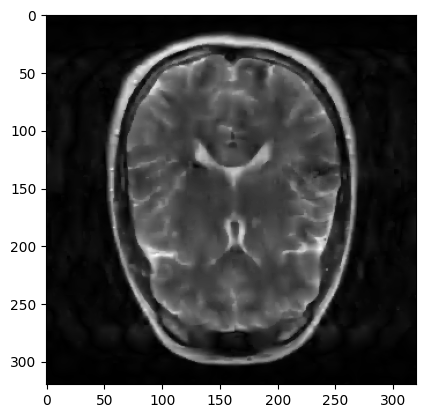

In [33]:
print(f"Min: {xTGV.squeeze().abs().min()}, Max: {xTGV.squeeze().abs().max()}")
plt.imshow(xTGV.squeeze().abs(), cmap="gray")

In [34]:
print(f"TGV PSNR custom: {custom_psnr(xTGV.squeeze(0), rescaled_x_true_example.squeeze(0))}")

TGV PSNR custom: 24.357593536376953


In [35]:
psnr_skimage = peak_signal_noise_ratio(
    rescaled_x_true_example.squeeze(0).abs().numpy(),
    xTGV.squeeze(0).abs().numpy()
)
print(f"TGV PSNR skimage: {psnr_skimage}")

TGV PSNR skimage: 24.35759349653489


In [36]:
psnr_skimage_range = peak_signal_noise_ratio(
    rescaled_x_true_example.squeeze(0).abs().numpy(),
    xTGV.squeeze(0).abs().numpy(),
    data_range=max(rescaled_x_true_example.squeeze(0).abs().max(), xTGV.squeeze(0).abs().max())
)
print(f"TGV PSNR skimage range: {psnr_skimage_range}")

TGV PSNR skimage range: 24.35759349653489


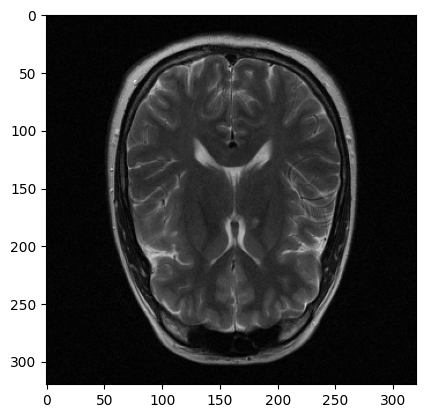

In [37]:
plt.imshow(x_true_example.squeeze(0).abs(), cmap="gray")

# PDHG Net

In [38]:
netsettings = dict(
    dim=2,
    n_ch_in=2,  # TODO: Why 2?
    # n_ch_in=1,
    # n_ch_out=n_ch_out,
    # n_ch_out=1,   # TV
    n_ch_out=2,   # TGV
    # n_enc_stages=args.E,
    n_enc_stages=3,
    # n_convs_per_stage=args.C,
    n_convs_per_stage=2,
    # n_filters=args.K,
    n_filters=32,
    res_connection=False, bias=True, padding_mode="reflect")

In [39]:
from networks.unet import UNet
def get_unet(netsettings: Dict) -> UNet:

    CNN_block = UNet(**netsettings)
    with torch.no_grad():

        def bias_to_zero(m):
            if hasattr(m, "bias") and m.bias is not None:
                m.bias.data.fill_(0)

        CNN_block.apply(bias_to_zero)
        # force initial lambdas to be closer to lower bound / zero
        CNN_block.c1x1.bias.fill_(-1.0)
    return CNN_block

In [40]:
from networks.mri_primal_dual import MriPrimalDual

device = "cpu"

CNN_block = get_unet(netsettings).to(device=device)

pdhg_net = MriPrimalDual(
    EncObj, CNN_block=CNN_block,
    # nu=args.nu[0],
    # nu=64,
    nu=256,     # Number of iterations for primal-dual algorithm
    # mode=args.mode,
    mode="lambda_cnn",
    # low_bound=args.low_bound,
    low_bound=0.0,
    # up_bound=None if args.up_bound == 0.0 else args.up_bound
    up_bound=None
).to(device=device)

In [41]:
dir = mkp(root_dir, "tmp", "mri_model_09_10-14_09")
file = "model_state_dict_50.pth"

In [42]:
pdhg_net.load_state_dict(torch.load(mkp(dir, file)))

<All keys matched successfully>

In [43]:
batch = rescaled_x_zero_filled.unsqueeze(0).to(device)
print(f"data type of rescaled_x_zero_filled: {rescaled_x_zero_filled.dtype}")

data type of rescaled_x_zero_filled: torch.complex64


In [44]:
batch_x_reconstructed_complex, lambda_reg = pdhg_net(
    x=rescaled_x_zero_filled,
    y=rescaled_kdata_noisy,
    mask=mask,
    csmap=None)

In [45]:
batch_x_reconstructed_complex_detached = batch_x_reconstructed_complex.cpu().detach()

In [46]:
print(f"shape of batch_x_reconstructed_complex_detached: {batch_x_reconstructed_complex_detached.shape}")

shape of batch_x_reconstructed_complex_detached: torch.Size([1, 320, 320])


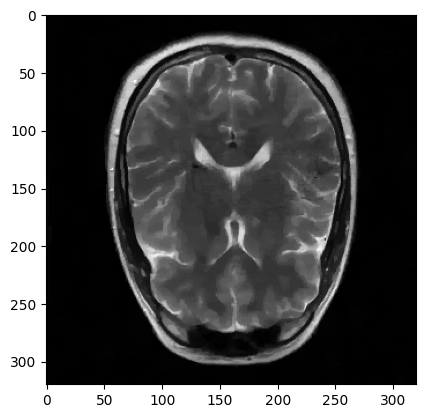

In [47]:
plt.imshow(batch_x_reconstructed_complex_detached.squeeze(0).abs(), cmap="gray")

In [48]:
print(f"TGV Map PSNR custom: {custom_psnr(batch_x_reconstructed_complex_detached.squeeze(0), rescaled_x_true_example.squeeze(0))}")

TGV Map PSNR custom: 25.910934448242188


In [49]:
print(f"TGV Map PSNR skimage: {peak_signal_noise_ratio(rescaled_x_true_example.squeeze(0).abs().numpy(), batch_x_reconstructed_complex_detached.squeeze(0).abs().numpy())}")

TGV Map PSNR skimage: 25.91093479433786


In [50]:
print(f"TGV Map PSNR skimage range: {peak_signal_noise_ratio(rescaled_x_true_example.squeeze(0).abs().numpy(), batch_x_reconstructed_complex_detached.squeeze(0).abs().numpy(), data_range=max(rescaled_x_true_example.squeeze(0).abs().max(), batch_x_reconstructed_complex_detached.squeeze(0).abs().max()))}")

TGV Map PSNR skimage range: 25.91093479433786


In [51]:
print(f"TGV Map PSNR skimage range 3: {peak_signal_noise_ratio(rescaled_x_true_example.squeeze(0).abs().numpy(), batch_x_reconstructed_complex_detached.squeeze(0).abs().numpy(), data_range=3)}")

TGV Map PSNR skimage range 3: 35.45335988873111


In [52]:
config_file = mkp(root_dir, "config", "example_mri_tgv_config.yaml")

In [53]:
from config.config_loader import load_config
config = load_config(config_file, is_training=False)

Config loaded from file ../config/example_mri_tgv_config.yaml


In [54]:
# device = "cuda"
device = "cpu"
config["log"]["model_filename"] = file
config["log"]["save_dir"] = dir
config["device"] = device

In [55]:
from scripts.mri.model_loader_old import ModelLoader
model_loader = ModelLoader(
    config_choice=config,
    is_training=False
)

Config loaded from dict


In [57]:
my_unet = model_loader.init_unet()

In [69]:
from networks.mri_pdhg_net_old import MriPdhgNet

In [70]:
my_pdhg_net = MriPdhgNet(
    device=device,
    pdhg_algorithm="tgv",
    # pdhg_algorithm="tv",
    T=256,
    # cnn=CNN_block,
    cnn=my_unet,
    params_config={
        "learns_sigma_and_tau": True,
    },
    # Bounds for the lambda values
    low_bound=0,
    up_bound=None,
    # NOTE: could not use "constant" or "zeros" padding for some reason
    padding="reflect"
)
my_pdhg_net.load_state_dict(torch.load(mkp(dir, file)))

Norm of operator A: 1
Norm of gradient operator nabla: 2.8284270763397217
L: 3.0


<All keys matched successfully>

In [60]:
my_reconstructed_batch = my_pdhg_net(
    kdata=rescaled_kdata_noisy.to(device),
    kmask=mask.to(device),
    x=rescaled_x_zero_filled.to(device),
    csmap=None,
    tqdm=tqdm
)
my_reconstructed_x,  lambda_reg = my_reconstructed_batch

shape of lambda_cnn: torch.Size([1, 2, 328, 328])
shape of lambda_scaled: torch.Size([1, 2, 320, 320])
shape of lambda0_w: torch.Size([1, 1, 320, 320])


  0%|          | 0/256 [00:00<?, ?it/s]

shape of lambda1_v: torch.Size([1, 1, 320, 320, 1, 1])
shape of p: torch.Size([1, 320, 320, 2])
data type of p: torch.complex64


In [70]:
# plt.imshow(
#     my_reconstructed_x.cpu().detach()[0][0].abs(), cmap="gray")

In [71]:
# my_tgv_map_psnr_custom = custom_psnr(my_reconstructed_x_detached.squeeze(0), rescaled_x_true_example.squeeze(0))
# print(f"My TGV Map PSNR custom: {my_tgv_map_psnr_custom}")

In [61]:
lambda_reg = my_pdhg_net.get_lambda_cnn(x=rescaled_x_zero_filled.to(device))

shape of lambda_cnn: torch.Size([1, 2, 328, 328])
shape of lambda_scaled: torch.Size([1, 2, 320, 320])
shape of lambda0_w: torch.Size([1, 1, 320, 320])


In [62]:
print(f"type(lambda_reg): {type(lambda_reg)}")

type(lambda_reg): <class 'dict'>


In [63]:
tv_pdhg_solver

MriPdhgTorch(
  (encoding_object): Cart2DEncObj()
  (pdhg_solver): TvPdhgTorch()
)

In [64]:
lambda_tv = lambda_reg["lambda1_v"]

In [65]:
my_reconstructed_x_2 = tv_pdhg_solver.forward(
    num_iters=256,
    lambda_reg=lambda_tv,
    kdata=rescaled_kdata_noisy,
    kmask=mask,
    state=rescaled_x_zero_filled,
    tqdm=tqdm
)

  0%|          | 0/256 [00:00<?, ?it/s]

shape of lambda_reg: torch.Size([1, 1, 320, 320, 1, 1])
shape of p: torch.Size([1, 320, 320, 2])
data type of p: torch.complex64


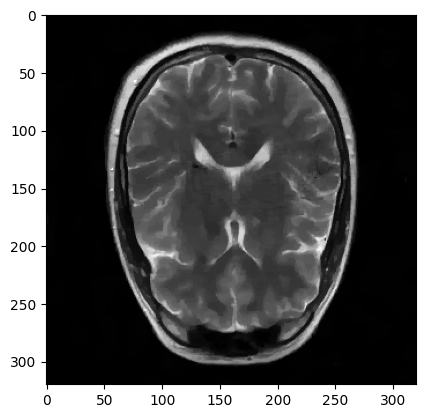

In [66]:
plt.imshow(
    my_reconstructed_x_2.cpu().detach()[0][0].abs(), cmap="gray")

In [105]:
my_tgv_map_psnr_custom_2 = custom_psnr(my_reconstructed_x_2.squeeze(0), rescaled_x_true_example.squeeze(0))
print(f"My TGV Map PSNR custom 2: {my_tgv_map_psnr_custom_2}")

My TGV Map PSNR custom 2: 25.88864517211914


In [106]:
test_tgv_reconstructed_x = my_pdhg_net.pdhg_solver.forward(
    num_iters=256,
    # lambda_reg={
    #     "lambda0_w": lambda_reg["lambda0_w"].unsqueeze(-1),
    #     "lambda1_v": lambda_reg["lambda1_v"].unsqueeze(-1)
    #     # "lambda0_w": 0.01,
    #     # "lambda1_v": 0.01
    # },
    lambda_reg=lambda_reg,
    kdata=rescaled_kdata_noisy,
    kmask=mask,
    state=rescaled_x_zero_filled,
    tqdm=tqdm
)

  0%|          | 0/256 [00:00<?, ?it/s]

shape of lambda1_v: torch.Size([1, 1, 320, 320, 1, 1])
shape of p: torch.Size([1, 320, 320, 2])
data type of p: torch.complex64


In [107]:
tgv_pdhg_solver = MriPdhgTorch(
    device="cpu",
    pdhg_algorithm="tgv",
)

In [111]:
test_tgv_reconstructed_x = tgv_pdhg_solver.forward(
    num_iters=256,
    # lambda_reg={
    #     "lambda0_w": lambda_reg["lambda0_w"].squeeze(0),
    #     "lambda1_v": lambda_reg["lambda1_v"].squeeze(0)
    #     # "lambda0_w": 0.01,
    #     # "lambda1_v": 0.01
    # },
    lambda_reg=lambda_reg,
    kdata=rescaled_kdata_noisy,
    kmask=mask,
    state=rescaled_x_zero_filled,
    tqdm=tqdm
)

  0%|          | 0/256 [00:00<?, ?it/s]

shape of lambda1_v: torch.Size([1, 1, 320, 320, 1, 1])
shape of p: torch.Size([1, 320, 320, 2])
data type of p: torch.complex64


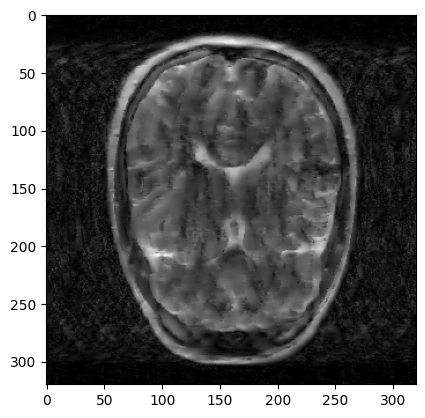

In [110]:
plt.imshow(
    test_tgv_reconstructed_x.cpu().detach()[0].abs(), cmap="gray")

# Others

In [ ]:
torch.nn.functional.mse_loss(
    torch.view_as_real(xTV),
    torch.view_as_real(x_true_example * rescale_factor)
)

In [ ]:
print(f"x_true_example data type: {x_true_example.dtype}")

In [ ]:
print(f"x_true_example shape: {x_true_example.shape}")

In [ ]:
print(f"x_true_example[0] shape: {x_true_example[0].shape}")

In [ ]:
print(f"x_true_example[0] data type: {x_true_example[0].dtype}")

In [ ]:
y = complex_number_x_true_to_real_number_results(x_true_example, R=6, noise_var=0)
print(f"len(y) = {len(y)}")

In [ ]:
# x_true_all_path = mkp(mri_data_dir, "x_true_all.pt")
# # x_true_all = torch.load(x_true_all_path)
# print(f"x_true_all shape: {x_true_all.shape}")

In [19]:
# img_true_all = []
# for i in range(x_true_all.shape[0]):
#     x_true = x_true_all[i, ...]
#     img_true = x_true.abs()
#     img_true_all.append(img_true)
#     # print(f"x_true shape: {x_true.shape}")
#     # print(f"x_true data type: {x_true.dtype}")
#     # print(f"img_true shape: {img_true.shape}")
#     # print(f"img_true data type: {img_true.dtype}")
#     # plt.imshow(img_true)
#     # break
# img_true_all = torch.stack(img_true_all)

img_true_all_path = mkp(mri_data_dir, "img_true_all.pt")
# img_true_all = torch.load(img_true_all_path)

In [ ]:
print(f"img_true_all shape: {img_true_all.shape}")
print(f"img_true_all data type: {img_true_all.dtype}")
print(f"img_true_all device: {img_true_all.device}")

In [ ]:
plt.imshow(img_true_all[0])

In [22]:
min_val = img_true_all.min()
max_val = img_true_all.max()

In [ ]:
print(f"min_val = {min_val}")
print(f"max_val = {max_val}")

In [24]:
img_true_all_path = mkp(mri_data_dir, "img_true_all.pt")

In [25]:
# torch.save(img_true_all, img_true_all_path)

In [26]:
# x_corrupted_all = []
# for i in range(x_true_all.shape[0]):
#     x_true = x_true_all[i]
#     x_true = x_true.unsqueeze(0)
#     arrs = x_true_to_arrs(x_true, R=6, noise_var=0)
#     print(f"x_true shape: {x_true.shape}")
#     print(f"x_true data type: {x_true.dtype}")
#     print(f"arrs[0] shape: {arrs[0].shape}")
#     print(f"arrs[0] data type: {arrs[0].dtype}")
#     # x_corrupted = x_true_to_x_corrupted(x_true, R=6, noise_var=0)
#     # # x_corrupted_all.append(x_corrupted)
#     # print(f"x_corrupted shape: {x_corrupted.shape}")
#     # print(f"x_corrupted data type: {x_corrupted.dtype}")
#     # plt.imshow(x_corrupted)
#     break

# arrs_all = x_true_to_arrs(x_true_all, R=6, noise_var=0)   RuntimeError: [enforce fail at alloc_cpu.cpp:117] err == 0. DefaultCPUAllocator: can't allocate memory: you tried to allocate 9761836236800 bytes. Error code 12 (Cannot allocate memory)

In [ ]:
x_corrupted_all_path = mkp(mri_data_dir, "x_corrupted_all.pt")
# x_corrupted_all = torch.load(x_corrupted_all_path)
print(f"x_corrupted_all shape: {x_corrupted_all.shape}")

In [28]:
# img_true_all = []
# for i in range(x_true_all.shape[0]):
#     x_true = x_true_all[i, ...]
#     img_true = x_true.abs()
#     img_true_all.append(img_true)
#     # print(f"x_true shape: {x_true.shape}")
#     # print(f"x_true data type: {x_true.dtype}")
#     # print(f"img_true shape: {img_true.shape}")
#     # print(f"img_true data type: {img_true.dtype}")
#     # plt.imshow(img_true)
#     # break
# img_true_all = torch.stack(img_true_all)

img_corrupted_all = []
for i in range(x_corrupted_all.shape[0]):
    x_corrupted = x_corrupted_all[i, ...]
    img_corrupted = x_corrupted.abs()
    img_corrupted_all.append(img_corrupted)
    # print(f"x_corrupted shape: {x_corrupted.shape}")
    # print(f"x_corrupted data type: {x_corrupted.dtype}")
    # print(f"img_corrupted shape: {img_corrupted.shape}")
    # print(f"img_corrupted data type: {img_corrupted.dtype}")
    # plt.imshow(img_corrupted)
    # break
img_corrupted_all = torch.stack(img_corrupted_all)

In [ ]:
print(f"img_corrupted_all shape: {img_corrupted_all.shape}")
print(f"img_corrupted_all data type: {img_corrupted_all.dtype}")
print(f"img_corrupted_all device: {img_corrupted_all.device}")

In [30]:
img_corrupted_all_path = mkp(mri_data_dir, "img_corrupted_all.pt")

In [31]:
# torch.save(img_corrupted_all, img_corrupted_all_path)

In [32]:
# x_corrupted_all = x_corrupted_all.squeeze(1)
# print(f"x_corrupted_all shape: {x_corrupted_all.shape}")

In [33]:
# torch.save(x_corrupted_all, x_corrupted_all_path)

In [ ]:
x_true_slice_id = 89  # only one slice for xtrue.pt
x_true_one_slice = x_true_all[[x_true_slice_id], ...]
print(f"x_true_one_slice shape: {x_true_one_slice.shape}")

In [ ]:
plot_example(x_true_one_slice)

In [ ]:
# Check if x_true_example and x_true are the same
print(torch.allclose(x_true_example, x_true_all[0]))

In [37]:
x_true_100_elements = x_true_all[:100, ...]

In [ ]:
print(f"x_true_100_elements shape: {x_true_100_elements.shape}")

In [39]:
x_true_100_elements_path = mkp(mri_data_dir, "x_true_100_elements.pt")

In [40]:
# torch.save(x_true_100_elements, x_true_100_elements_path)

In [ ]:
print(f"x_true_all data type: {x_true_all.dtype}")

In [ ]:
print(f"x_true_all shape: {x_true_all.shape}")

In [ ]:
print(f"x_true_all data type: {x_true_all.dtype}")

In [44]:
# plt.imshow(x_true_all[0])     TypeError: Image data of dtype complex64 cannot be converted to float

In [ ]:
print(x_true_all[0][0][0])

# Make kdata

In [ ]:
kdata_100_elements = []
kdata_100_elements_noisy = []
for i in tqdm(range(100)):
    x_true_1_element = x_true_100_elements[[i], ...]
    kdata_full, kdata_full_noisy, kdata, kdata_noisy, csm, mask, EncObj = complex_number_x_true_to_kdata(x_true_1_element, R=6, noise_var=0.01)
    kdata_100_elements_noisy.append(kdata_noisy)
    kdata_100_elements.append(kdata)

kdata_100_elements = torch.stack(kdata_100_elements)
kdata_100_elements = kdata_100_elements.squeeze(1)
kdata_100_elements = kdata_100_elements.squeeze(1)

kdata_100_elements_noisy = torch.stack(kdata_100_elements_noisy)
kdata_100_elements_noisy = kdata_100_elements_noisy.squeeze(1)
kdata_100_elements_noisy = kdata_100_elements_noisy.squeeze(1)

In [ ]:
print(f"kdata_100_elements shape: {kdata_100_elements.shape}")
print(f"kdata_100_elements_noisy shape: {kdata_100_elements_noisy.shape}")

In [48]:
# kdata_100_elements_path = mkp(mri_data_dir, "kdata_100_elements.pt")
# torch.save(kdata_100_elements, kdata_100_elements_path)

In [49]:
# kdata_100_elements_noisy_path = mkp(mri_data_dir, "kdata_100_elements_noisy.pt")
# torch.save(kdata_100_elements_noisy, kdata_100_elements_noisy_path)

In [ ]:
x_true_all.shape[0]

In [ ]:
kdata_all = []
kdata_all_noisy = []
for i in tqdm(range(x_true_all.shape[0])):
    # x_true_1_element = x_true_all[[i], ...]
    x_true_1_element = x_true_all[i]
    kdata_full, kdata_full_noisy, kdata, kdata_noisy, csm, mask, EncObj = complex_number_x_true_to_kdata(x_true_1_element, R=6, noise_var=0.01)
    kdata_all_noisy.append(kdata_noisy)
    kdata_all.append(kdata)
kdata_all = torch.stack(kdata_all)
kdata_all = kdata_all.squeeze(1)
kdata_all = kdata_all.squeeze(1)

kdata_all_noisy = torch.stack(kdata_all_noisy)
kdata_all_noisy = kdata_all_noisy.squeeze(1)
kdata_all_noisy = kdata_all_noisy.squeeze(1)

In [ ]:
x_corrupted_all = []
# for slice_id in tqdm(range(x_true_100_elements.shape[0])): # only one slice for xtrue
for slice_id in tqdm(range(x_true_all.shape[0])):
    x_true_one_slice = x_true_all[[slice_id], ...]
    # print(f"x_true_one_slice shape: {x_true_one_slice.shape}")
    x_corrupted = complex_number_x_true_to_real_number_x_corrupted(x_true_one_slice, R=6, noise_var=0)
    x_corrupted_all.append(x_corrupted)
x_corrupted_all = torch.stack(x_corrupted_all)
# print(f"x_corrupted_all shape: {x_corrupted_all.shape}")

In [ ]:
print(f"x_corrupted_all shape: {x_corrupted_all.shape}")

In [ ]:
# Convert shape from (100, 1, 256, 256) to (100, 256, 256)
x_corrupted_all = x_corrupted_all.squeeze(1)
print(f"x_corrupted_all shape: {x_corrupted_all.shape}")

In [ ]:
# x_corrupted_path_all = mkp(mri_data_dir, "x_corrupted_all.pt")
# torch.save(x_corrupted_all, x_corrupted_path_all)